In [1]:
"""pydca demo

Author: Evan Cresswell-Clay
"""
import sys,os
import data_processing as dp
import ecc_tools as tools
import timeit
# import pydca-ER module
from pydca.erdca import erdca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.msa_trimmer.msa_trimmer import MSATrimmerException
from pydca.dca_utilities import dca_utilities
import numpy as np
import pickle
from gen_ROC_jobID_df import add_ROC
import matplotlib.pyplot as plt

# Import Bio data processing features 
import Bio.PDB, warnings
from Bio.PDB import *
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning

warnings.filterwarnings("error")
warnings.simplefilter('ignore', BiopythonWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ResourceWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")



pfam_id = 'PF00186'
pfam_id = 'PF02146'
pfam_id = 'PF17795'

protein_msa_file = 'orig_MSA_%s.fa'%pfam_id
protein_refseq_file = 'orig_ref_%s.fa'%pfam_id
#protein_msa_file = 'MSA_PF00186.fa'
#protein_refseq_file = 'ref_PF00186.fa'

## Use Polypeptide Sequence from PDB as your reference sequence in MSA.

In [2]:

data_path = '../../../Pfam-A.full'
data_path = '/data/cresswellclayec/hoangd2_data/Pfam-A.full'
data_path = '/home/eclay/Pfam-A.full'

# Read in Reference Protein Structure
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))
# convert bytes to str (python 2 to python 3)                                                                       
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0])      for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])
ipdb = 0
tpdb = int(pdb[ipdb,1])
print('Ref Sequence # should be : ',tpdb-1)

# Load Multiple Sequence Alignment
s = dp.load_msa(data_path,pfam_id)

# Load Polypeptide Sequence from PDB as reference sequence
print(pdb[ipdb,:])
pdb_id = pdb[ipdb,5]
pdb_chain = pdb[ipdb,6]
pdb_start,pdb_end = int(pdb[ipdb,7]),int(pdb[ipdb,8])
#print('pdb id, chain, start, end, length:',pdb_id,pdb_chain,pdb_start,pdb_end,pdb_end-pdb_start+1)                        

#print('download pdb file')                                                                       
pdb_file = pdb_list.retrieve_pdb_file(str(pdb_id),file_format='pdb')
#pdb_file = pdb_list.retrieve_pdb_file(pdb_id)                                                    
#---------------------------------------------------------------------------------------------------------------------#            
chain = pdb_parser.get_structure(str(pdb_id),pdb_file)[0][pdb_chain]
ppb = PPBuilder().build_peptides(chain)
#    print(pp.get_sequence())
print('peptide build of chain produced %d elements'%(len(ppb)))

found_match = True
matching_seq_dict = {}
poly_seq = list()
for i,pp in enumerate(ppb):
    for char in str(pp.get_sequence()):
        poly_seq.append(char)    
print('PDB Polypeptide Sequence: \n',poly_seq)
#check that poly_seq matches up with given MSA
    
pp_msa_file, pp_ref_file = tools.write_FASTA(poly_seq, s, pfam_id, number_form=False,processed=False)

        



Ref Sequence # should be :  2
shape of s (import from msa.npy):
 (271, 139)
shape of s (after UTF-8 decode):
 (271, 139)
['PF17795' '3' 'MVP_RAT' '457' '518' '4HL8' 'A' '457' '518']
peptide build of chain produced 3 elements
PDB Polypeptide Sequence: 
 ['E', 'A', 'I', 'I', 'R', 'I', 'P', 'P', 'Y', 'H', 'Y', 'I', 'H', 'V', 'L', 'D', 'Q', 'N', 'S', 'N', 'V', 'S', 'R', 'V', 'E', 'V', 'G', 'P', 'K', 'T', 'Y', 'I', 'R', 'Q', 'D', 'N', 'E', 'R', 'V', 'L', 'F', 'A', 'P', 'V', 'R', 'M', 'V', 'T', 'V', 'P', 'P', 'R', 'H', 'Y', 'C', 'I', 'V', 'A', 'N', 'P', 'V', 'S', 'R', 'D', 'T', 'Q', 'S', 'S', 'V', 'L', 'F', 'D', 'I', 'T', 'G', 'Q', 'V', 'R', 'L', 'R', 'H', 'A', 'D', 'Q', 'E', 'I', 'R', 'L', 'A', 'Q', 'D', 'P', 'F', 'P', 'L', 'Y', 'P', 'G', 'E', 'V', 'L', 'E', 'K', 'D', 'I', 'T', 'P', 'L', 'Q', 'V', 'V', 'L', 'P', 'N', 'T', 'A', 'L', 'H', 'L', 'K', 'A', 'L', 'L', 'D', 'F', 'E', 'D', 'K', 'N', 'G', 'D', 'K', 'V', 'M', 'A', 'G', 'D', 'E', 'W', 'L', 'F', 'E', 'G', 'P', 'G', 'T', 'Y', 'I', 'P', '

In [3]:
#just add using muscle:
#https://www.drive5.com/muscle/manual/addtomsa.html
muscling = False
muscle_msa_file = 'PP_muscle_msa_'+pfam_id+'.fa'
if muscling:
        #just add using muscle:
        #https://www.drive5.com/muscle/manual/addtomsa.html
        #https://www.drive5.com/muscle/downloads.htmL
        os.system("./muscle -profile -in1 %s -in2 %s -out %s"%(pp_msa_file,pp_ref_file,muscle_msa_file))
        print("PP sequence added to alignment via MUSCLE")


In [4]:
preprocessing = True

preprocessed_data_outfile = 'MSA_%s_PreProcessed.fa'%pfam_id
if preprocessing:
        # create MSATrimmer instance 
        if muscling:
            trimmer = msa_trimmer.MSATrimmer(
                muscle_msa_file, biomolecule='PROTEIN',
                refseq_file=pp_ref_file
            )
        else:
            trimmer = msa_trimmer.MSATrimmer(
                pp_msa_file, biomolecule='PROTEIN',
                refseq_file=pp_ref_file
            )  

        # Adding the data_processing() curation from tools to erdca.
        try:
                preprocessed_data,s_index, cols_removed,s_ipdb,s = trimmer.get_preprocessed_msa(printing=True, saving = False)
        except(MSATrimmerException):
                ERR = 'PPseq-MSA'
                print('Error with MSA trimms (%s)'%ERR)
                sys.exit()

        # Save processed data dictionary and FASTA file
        pfam_dict = {}
        pfam_dict['s0'] = s
        pfam_dict['msa'] = preprocessed_data
        pfam_dict['s_index'] = s_index
        pfam_dict['s_ipdb'] = s_ipdb
        pfam_dict['cols_removed'] = cols_removed

        input_data_file = "pfam_ecc/%s_DP.pickle"%(pfam_id)
        with open(input_data_file,"wb") as f:
                pickle.dump(pfam_dict, f)
        f.close()

        #write trimmed msa to file in FASTA format
        with open(preprocessed_data_outfile, 'w') as fh:
            for seqid, seq in preprocessed_data:
                fh.write('>{}\n{}\n'.format(seqid, seq))
else:
        input_data_file = "pfam_ecc/%s_DP.pickle"%(pfam_id)
        with open(input_data_file,"rb") as f:
                pfam_dict =  pickle.load(f)
        f.close()
        cols_removed = pfam_dict['cols_removed']
        s_index= pfam_dict['s_index']
        s_ipdb = pfam_dict['s_ipdb']




sequence indices which match ref seq: 
 [2]
sequences which match ref seq: 
 ['--------VVSYRVPHNAAVQVYDYRAKRARVVF--GPELVTLDPEEQFTVLSLSA----------G----------R----------P--------K--RPHARRALCLLL---------------------------'] 

#------------------------------------------------#

first matching indx in alignment:  0
first matching seq: in alignment:  --------VVSYRVPHNAAVQVYDYRAKRARVVF--GPELVTLDPEEQFTVLSLSA----------G----------R----------P--------K--RPHARRALCLLL---------------------------
['V', 'V', 'S', 'Y', 'R', 'V', 'P', 'H', 'N', 'A', 'A', 'V', 'Q', 'V', 'Y', 'D', 'Y', 'R', 'A', 'K', 'R', 'A', 'R', 'V', 'V', 'F', 'G', 'P', 'E', 'L', 'V', 'T', 'L', 'D', 'P', 'E', 'E', 'Q', 'F', 'T', 'V', 'L', 'S', 'L', 'S', 'A', 'G', 'R', 'P', 'K', 'R', 'P', 'H', 'A', 'R', 'R', 'A', 'L', 'C', 'L', 'L', 'L']
['V', 'V', 'S', 'Y', 'R', 'V', 'P', 'H', 'N', 'A', 'A', 'V', 'Q', 'V', 'Y', 'D', 'Y', 'R', 'A', 'K', 'R', 'A', 'R', 'V', 'V', 'F', 'G', 'P', 'E', 'L', 'V', 'T', 'L', 'D', 'P', 'E', 'E', 'Q', 'F', 'T', '

In [5]:
computing_DI = True
if computing_DI:
        # Compute DI scores using Expectation Reflection algorithm
        erdca_inst = erdca.ERDCA(
            preprocessed_data_outfile,
            'PROTEIN',
            s_index = s_index,
            pseudocount = 0.5,
            num_threads = 4,
            seqid = 0.8)

        # Compute average product corrected Frobenius norm of the couplings
        start_time = timeit.default_timer()
        erdca_DI = erdca_inst.compute_sorted_DI()
        run_time = timeit.default_timer() - start_time
        print('ER run time:',run_time)

        for site_pair, score in erdca_DI[:5]:
            print(site_pair, score)

        with open('DI/ER/er_DI_%s.pickle'%(pfam_id), 'wb') as f:
            pickle.dump(erdca_DI, f)
        f.close()
else:
        with open('DI/ER/er_DI_%s.pickle'%(pfam_id), 'rb') as f:
            erdca_DI = pickle.load( f)
        f.close()


Not accounting for sequence similarity...
    (must get Joblib, Parallel working first)
Computing site pair DI scores
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
(167, 35)
Compute ER weights in parallel using 4 threads for 35 variables
matrix s: shape:  (167, 271) 


Done Parallel processing
ER couplings dimensions:  (271, 271)
Sorting DI scores
Imposing Distance Restraint
[((3, 4), 0.02834366256208677), ((4, 3), 0.02834366256208677), ((7, 6), 0.02394557158552052), ((6, 7), 0.02394557158552052), ((18, 22), 0.02213401512836599), ((22, 18)

Using chain  A
PDB ID:  4HL8
NEW VERSION
odict_keys(['A'])
((35, 45), (45, 54), (45, 53), (21, 41), (13, 45), (31, 45), (9, 52), (51, 57), (21, 56), (13, 58), (35, 47), (13, 40), (4, 19), (47, 52), (4, 21), (37, 53), (46, 57), (37, 60), (9, 41), (29, 51), (9, 28), (13, 37), (46, 55), (18, 33), (9, 58), (9, 60), (17, 35), (40, 54), (10, 23), (47, 57), (3, 10), (13, 56), (17, 47), (3, 45), (45, 52), (29, 57), (5, 28), (46, 54), (37, 52), (20, 33), (13, 41), (3, 31), (24, 56), (21, 52), (13, 18), (35, 55), (13, 19), (19, 24), (2, 37), (35, 54), (13, 31), (13, 29), (2, 13), (9, 17), (4, 23), (21, 45), (55, 60), (21, 60), (50, 55), (9, 29), (9, 21), (31, 54), (19, 47), (10, 29), (17, 28), (3, 37), (23, 37), (28, 47), (9, 35), (5, 56), (37, 56), (13, 54), (2, 56), (23, 47), (4, 57), (9, 37), (28, 40), (28, 35), (35, 52), (17, 46), (13, 50), (35, 57), (35, 53), (18, 37), (4, 28), (4, 13), (35, 46), (3, 40), (4, 45), (4, 41), (3, 28), (10, 19), (21, 28), (41, 51), (17, 45), (5, 24), (37, 45), 

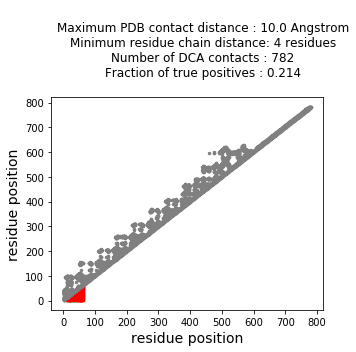

dict_keys(['tp', 'fp', 'missing', 'pdb'])
TP contacts:  111
FP contacts:  408
Missing Contacts:  0
PDB Contacts  10784
odict_keys(['A'])


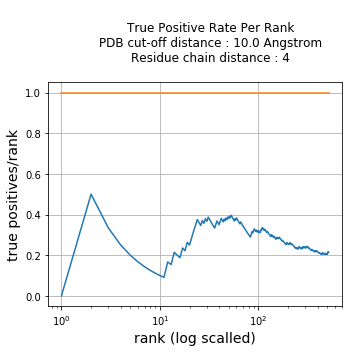

2
519
519
AxesSubplot(0.143542,0.137778;0.816736x0.621111)


In [6]:
# Print Details of protein PDB structure Info for contact visualizeation
print('Using chain ',pdb_chain)
print('PDB ID: ', pdb_id)

from pydca.contact_visualizer import contact_visualizer

erdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
refseq_file = pp_ref_file,
sorted_dca_scores = erdca_DI,
linear_dist = 4,
contact_dist = 10.)

er_contact_map_data = erdca_visualizer.plot_contact_map()
plt.show()
plt.savefig('contact_map_%s.pdf'%pfam_id)
print(er_contact_map_data.keys())
print("TP contacts: ",len(er_contact_map_data['tp']))
print("FP contacts: ",len(er_contact_map_data['fp']))
print("Missing Contacts: ",len(er_contact_map_data['missing']))
print("PDB Contacts ",len(er_contact_map_data['pdb']))


plt.close()
er_tp_rate_data = erdca_visualizer.plot_true_positive_rates()
plt.show()
print(len(er_tp_rate_data))
print(len(er_tp_rate_data[0]['dca']))
print(len(er_tp_rate_data[0]['pdb']))
print(er_tp_rate_data[1])

plt.savefig('TP_rate_%s.pdf'%pfam_id)
plt.close()
